In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_LPC_Mg.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 49 × 17747
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
BAMs,0,9
Mg_A,4,7
Mg_B,3,8
Mg_trt,3,9
cycl,0,6


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['Mg_A', 'BAMs'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (20, 17747)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Pandey et al. 2022': 'Pandey'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-0-0-0-0,(this study),ctrl,Mg_A,1,ctrl_1,LPC_Saline_2,Adams,114835,11.651252,1,Mg_A_LPC_Saline_2
donor_ctrl_2_0-0-0-0-0,(this study),ctrl,Mg_A,2,ctrl_2,LPC_Saline_1,Adams,269101,12.502842,2,Mg_A_LPC_Saline_1
donor_ctrl_4_0-0-0-0-0,Pandey et al. 2022,ctrl,Mg_A,4,ctrl_4,LPC_ctrl_2,Pandey,443698,13.002899,4,Mg_A_LPC_ctrl_2
donor_ctrl_5_0-0-0-0-0,Pandey et al. 2022,ctrl,Mg_A,5,ctrl_5,LPC_ctrl_1,Pandey,1883265,14.448518,5,Mg_A_LPC_ctrl_1
donor_stim_1_0-0-0-0-0,(this study),stim,Mg_A,1,stim_1,LPC_7d_2,Adams,366936,12.812943,1,Mg_A_LPC_7d_2


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

Mg_A_LPC_Saline_2
Mg_A_LPC_Saline_1
Mg_A_LPC_ctrl_2
Mg_A_LPC_ctrl_1
Mg_A_LPC_7d_2
Mg_A_LPC_5d_4
Mg_A_LPC_7d_1
Mg_A_LPC_5d_1
Mg_A_LPC_28d_3
Mg_A_LPC_28d_1
Mg_A_LPC_28d_2
BAMs_LPC_7d_2
BAMs_LPC_5d_4
BAMs_LPC_7d_1
BAMs_LPC_5d_1
BAMs_LPC_5d_3
BAMs_LPC_28d_3
BAMs_LPC_28d_1
BAMs_LPC_5d_2
BAMs_LPC_28d_2


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                            'Mg_A_LPC_Saline_2',
                            'Mg_A_LPC_Saline_1',
                            'Mg_A_LPC_ctrl_2',
                            'Mg_A_LPC_ctrl_1',
                            'BAMs_LPC_7d_2',
                            'BAMs_LPC_5d_4',
                            'BAMs_LPC_5d_3',
                            'BAMs_LPC_7d_1',
                            'BAMs_LPC_5d_2',
                            'BAMs_LPC_5d_1'                 
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (10, 17747)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
LPC_Saline_2,(this study),ctrl,Mg_A,1,ctrl_1,Adams,114835,11.651252,1,Mg_A_LPC_Saline_2
LPC_Saline_1,(this study),ctrl,Mg_A,2,ctrl_2,Adams,269101,12.502842,2,Mg_A_LPC_Saline_1
LPC_ctrl_2,Pandey et al. 2022,ctrl,Mg_A,4,ctrl_4,Pandey,443698,13.002899,4,Mg_A_LPC_ctrl_2
LPC_ctrl_1,Pandey et al. 2022,ctrl,Mg_A,5,ctrl_5,Pandey,1883265,14.448518,5,Mg_A_LPC_ctrl_1
LPC_7d_2,(this study),stim,BAMs,1,stim_1,Adams,229152,12.342141,1,BAMs_LPC_7d_2
LPC_5d_4,Pandey et al. 2022,stim,BAMs,11,stim_11,Pandey,14508038,16.490213,11,BAMs_LPC_5d_4
LPC_7d_1,(this study),stim,BAMs,2,stim_2,Adams,560715,13.236968,2,BAMs_LPC_7d_1
LPC_5d_1,Pandey et al. 2022,stim,BAMs,3,stim_3,Pandey,3684988,15.119778,3,BAMs_LPC_5d_1
LPC_5d_3,Pandey et al. 2022,stim,BAMs,4,stim_4,Pandey,15289272,16.542662,4,BAMs_LPC_5d_3
LPC_5d_2,Pandey et al. 2022,stim,BAMs,7,stim_7,Pandey,3703750,15.124856,7,BAMs_LPC_5d_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[ 0  0  2  0 11]
 [ 0  6  2  3 12]
 [ 0 11  2  2 16]
 [ 0 21  3 12 42]
 [ 0  2  5  1 30]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

             Group Reps  Batch
LPC_Saline_2  ctrl    1  Adams
LPC_Saline_1  ctrl    2  Adams
LPC_ctrl_2    ctrl    4 Pandey
LPC_ctrl_1    ctrl    5 Pandey
LPC_7d_2      stim    1  Adams
LPC_5d_4      stim   11 Pandey
LPC_7d_1      stim    2  Adams
LPC_5d_1      stim    3 Pandey
LPC_5d_3      stim    4 Pandey
LPC_5d_2      stim    7 Pandey


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 17747    10

ctrl stim 
   4    6 


In [17]:
%%R

cd <- x$samples$group
print(cd)

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
print(design)

 [1] ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim
   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       0      1
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [18]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 9436   10


In [19]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 9436   10


In [20]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 4.035023 1.200171


In [21]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.7282032 1.5832725 1.0165080 0.9634091 1.4747644 0.6686708 1.3646220
 [8] 0.7518737 0.5845647 0.6309619


In [22]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

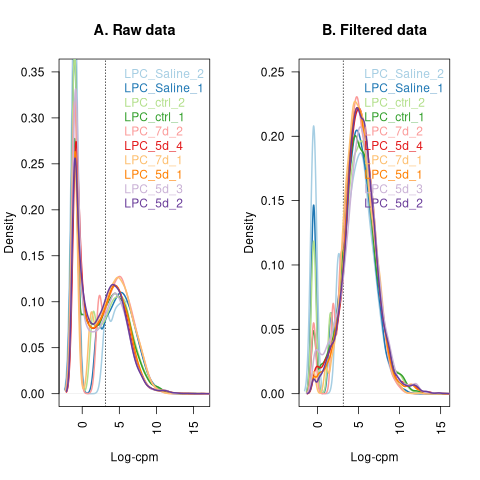

In [23]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

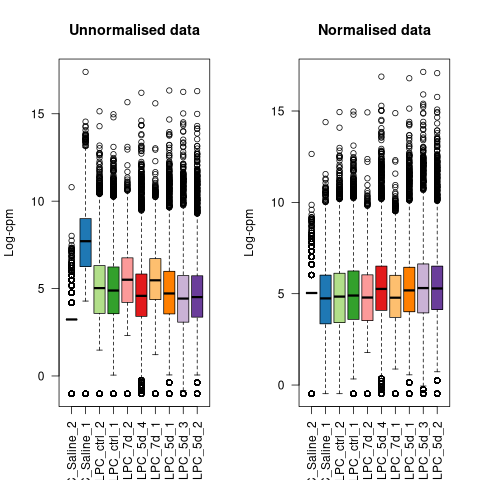

In [24]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [25]:
%%R
cd <- x2$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [26]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

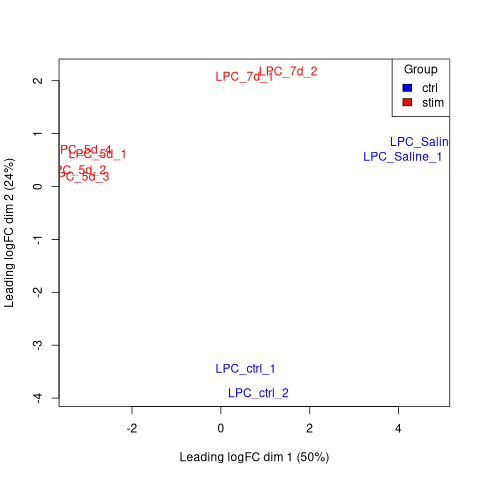

In [27]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

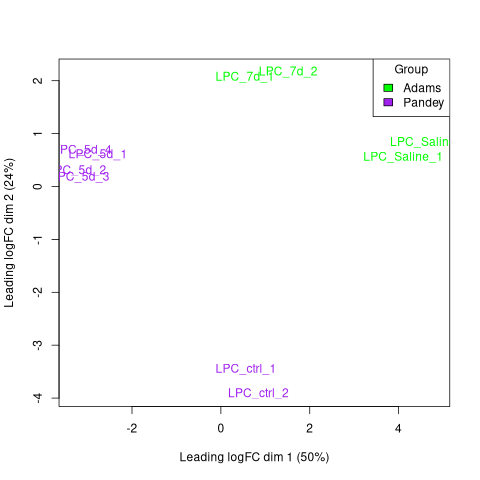

In [28]:
%%R
# Generate a numeric vector from group factors (if not already factor, convert it)
pub_factor <- as.factor(batch)
pub_colors <- as.numeric(pub_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("green", "purple")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[pub_colors])

# Adding a legend for clarity
legend("topright", legend=levels(pub_factor), fill=colors, title="Group")

In [29]:
%%R

x3$samples

             group lib.size norm.factors
LPC_Saline_2  ctrl   112276    1.7282032
LPC_Saline_1  ctrl   262949    1.5832725
LPC_ctrl_2    ctrl   435815    1.0165080
LPC_ctrl_1    ctrl  1854212    0.9634091
LPC_7d_2      stim   222373    1.4747644
LPC_5d_4      stim 14388349    0.6686708
LPC_7d_1      stim   546130    1.3646220
LPC_5d_1      stim  3653359    0.7518737
LPC_5d_3      stim 15202804    0.5845647
LPC_5d_2      stim  3671961    0.6309619


In [30]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       0      1
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [31]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [32]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [33]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=batch) 

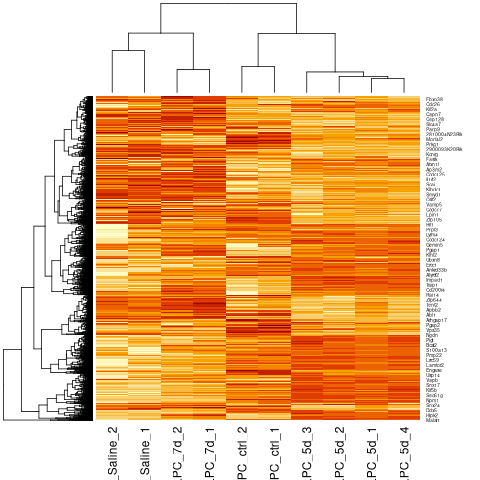

In [34]:
%%R
heatmap(logCPM)

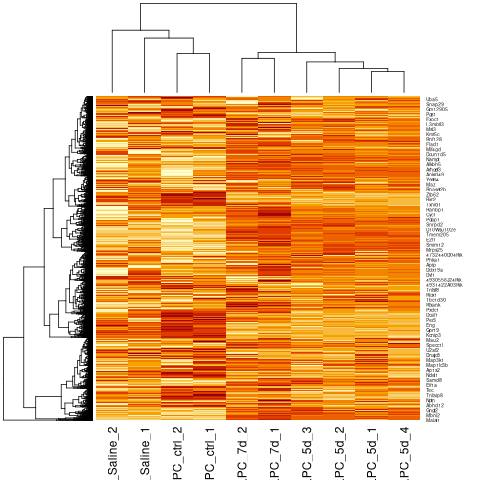

In [35]:
%%R
heatmap(logCPM_no_batch)

# Voom with quality weights

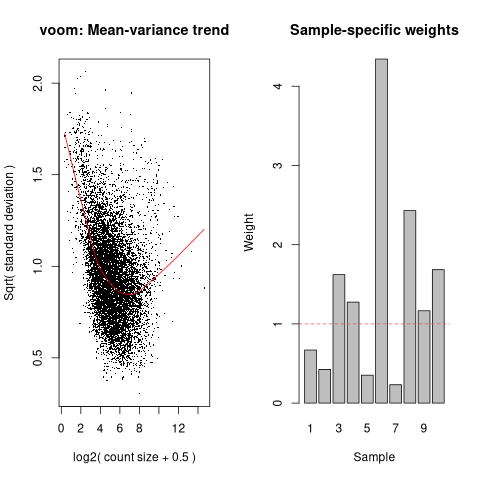

In [36]:
%%R
y <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [37]:
%%R
corfit <- duplicateCorrelation(y, design, block=batch)
corfit$consensus.correlation

[1] 0.4547755


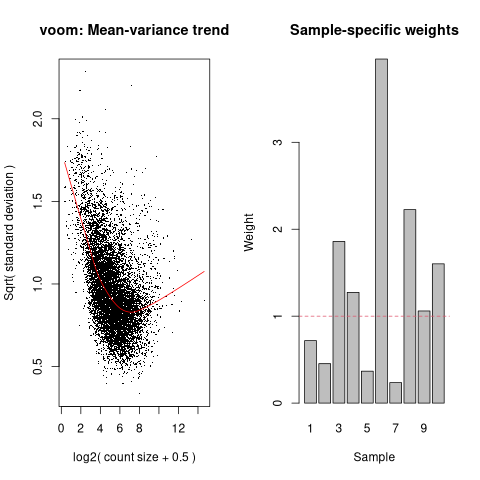

In [38]:
%%R
y2 <- voomWithQualityWeights(x2$counts, design, plot=TRUE, block=batch, correlation=corfit$consensus)

In [39]:
%%R
corfit2 <- duplicateCorrelation(y2,design,block=batch, weights=y2$targets$sample.weights)
corfit2$consensus.correlation

[1] 0.6028909


In [40]:
%%R
fit <- lmFit(y2, design, block=batch, correlation=corfit2$consensus)

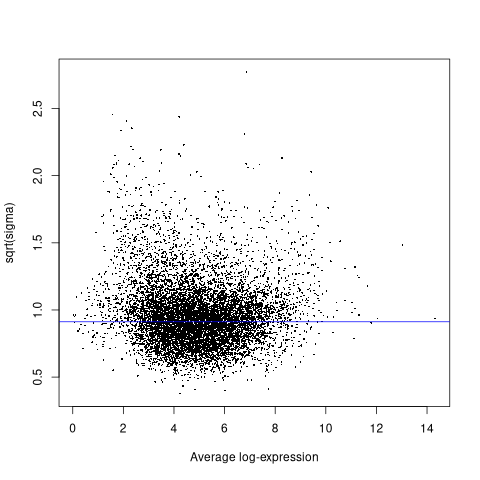

In [41]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [42]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

             logFC  AveExpr         t      P.Value    adj.P.Val        B
Pard3b   -6.801965 4.555290 -41.83255 9.591675e-15 9.050705e-11 23.38449
Sall1    -7.340231 3.624955 -35.65494 6.874848e-14 2.937501e-10 21.45388
Rtn4rl1  -6.700666 3.814156 -34.77837 9.339236e-14 2.937501e-10 21.28269
Slc40a1  -5.621230 3.296996 -30.91393 3.971833e-13 7.980891e-10 20.11820
BC035044 -5.620605 3.439808 -30.20635 5.276902e-13 7.980891e-10 19.76345
Snta1    -4.572477 4.837670 -30.13838 5.424757e-13 7.980891e-10 20.10148
Tjp1     -7.051892 3.878062 -29.66632 6.583597e-13 7.980891e-10 19.54333
Agmo     -5.917081 6.116336 -29.44000 7.231644e-13 7.980891e-10 19.92626
Ifitm10  -5.451535 5.554063 -29.31711 7.612125e-13 7.980891e-10 19.87012
Cables1  -6.268778 4.145495 -28.59148 1.034845e-12 8.947176e-10 19.49610


In [43]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 5213


In [44]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 4922


In [45]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 4099


In [46]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 1222
           logFC  AveExpr         t      P.Value    adj.P.Val         B
Spp1   13.604488 8.051441  7.091438 1.046171e-05 7.179393e-05  3.580868
Gpnmb  12.431175 8.109652 13.774847 6.810086e-09 2.304065e-07  8.633194
Fabp5  12.000838 7.068572  5.870494 6.605019e-05 3.209318e-04  1.932867
Lgals3 11.675251 6.993482  7.131681 9.878422e-06 6.884253e-05  3.535873
Wfdc17  9.615664 5.152937  3.544077 3.841180e-03 9.404613e-03 -1.698413
Ms4a7   9.543407 5.733025  9.631528 4.045931e-07 5.614324e-06  5.585926


In [47]:
%%R
if ('Apoe' %in% rownames(genes_up_sorted)) {
    print("gene IS in the index of genes_up_sorted")
} else {
    print("gene is NOT in the index of genes_up_sorted")
}

[1] "gene IS in the index of genes_up_sorted"


In [48]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 2877
             logFC  AveExpr          t      P.Value    adj.P.Val         B
Gm10790 -11.632284 3.531510  -9.887962 3.023452e-07 4.492802e-06  6.557390
Chst8   -10.515764 1.968095 -11.175261 7.630003e-08 1.535111e-06  7.487098
Crybb1  -10.507488 3.742704 -17.198378 4.915865e-10 3.403428e-08 13.036042
Sall3   -10.239389 2.441753  -9.479467 4.822709e-07 6.338034e-06  6.135775
Csmd3   -10.198569 6.084014 -25.145002 4.975704e-12 1.878030e-09 17.986635
Asb2     -9.905395 1.870112  -9.566846 4.358601e-07 5.934741e-06  6.085060


# Save output- make sure to rename!

In [49]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/LPC_demyel_Mg_A_v_BAMs_voom_wqw_NEW.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Do results overlap with LR pairs?

In [50]:
import liana as li
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [51]:
DEG_all = pd.read_csv('./files/LPC_demyel_Mg_A_v_BAMs_voom_wqw_NEW.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(9436, 7)

In [52]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(4099, 7)

In [53]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 120


,ligand,receptor,logFC_ligand,logFC_receptor
47,Spp1,Ptger4,13.604488,1.754633
46,Spp1,Cd44,13.604488,4.511076
113,Lgals3,Eng,11.675251,-3.402880
54,Lgals3,Lag3,11.675251,-8.452979
72,F13a1,Itga4,8.550647,5.381526
...,...,...,...,...
38,Angptl7,Pirb,-5.323091,1.662738
111,Sparc,Eng,-5.487260,-3.402880
40,Pdgfb,Lrp1,-5.720755,1.025821
75,Cfh,Itgam,-7.353885,-1.692274


In [54]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(1222, 7)

In [55]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 33


,ligand,receptor,logFC_ligand,logFC_receptor
14,Spp1,Cd44,13.604488,4.511076
15,Spp1,Ptger4,13.604488,1.754633
18,F13a1,Itga4,8.550647,5.381526
12,Apoc2,Lrp1,8.464866,1.025821
13,Igf1,Igf2r,7.742716,6.234506
25,Vim,Cd44,7.514038,4.511076
17,Apoe,Sorl1,7.005203,2.421698
11,Apoe,Lrp1,7.005203,1.025821
26,Apoe,Abca1,7.005203,1.447572
29,Vegfa,Cd44,6.669193,4.511076


In [56]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('LR_LPC_de_BAMs_NEW.csv', sep='\t', index=False)